# Runs numerics for mean field model and numerics in finite state space continuous time Markov chain with N listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json

In [2]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [3]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/Users/rohanalur/rsch/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0'] + ['mrd_direct', 'mrd_spillover_seller', 'mrd_spillover_buyer', 'mrd_avg']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

In [6]:
T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in lams}
T_end = {lam: T_1/min(lam,tau) for lam in lams}

varying_time_horizons = True

n_runs = 3
n_listings = 3

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

In [7]:
choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

In [8]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

## Herding

In [9]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  6.46
lambda= 1
Time elapsed:  5.44
lambda= 10
Time elapsed:  5.71


In [10]:
est_stats_herding

est       gte      bias  bias_over_GTE  \
estimator_type       lambda                                                
cr                   0.1     0.066667  0.041596  0.025071       0.602722   
                     1.0    -0.100000  0.031069 -0.131069      -4.218658   
                     10.0    0.133333  0.039333  0.094001       2.389883   
lr                   0.1     0.044444  0.041596  0.002849       0.068482   
                     1.0     0.000000  0.031069 -0.031069      -1.000000   
                     10.0    0.077778  0.039333  0.038445       0.977432   
tsr_est_naive        0.1    -0.025030  0.041596 -0.066626      -1.601748   
                     1.0     0.240986  0.031069  0.209918       6.756529   
                     10.0    0.133308  0.039333  0.093975       2.389229   
tsri_1.0             0.1    -0.009205  0.041596 -0.050801      -1.221307   
                     1.0     0.260776  0.031069  0.229707       7.393488   
                     10.0    0.133330  0.039333  0.093998       2.389806   
tsri_2.0             0.1     0.007447  0.041596 -0.034149      -0.820960   
                     1.0     0.291584  0.031069  0.260515       8.385086   
                     10.0    0.133353  0.039333  0.094020       2.390383   
mrd_direct           0.1    -0.044262  0.041596 -0.085858      -2.064106   
                     1.0     0.146224  0.031069  0.115155       3.706447   
                     10.0    0.133285  0.039333  0.093952       2.388652   
mrd_spillover_seller 0.1     0.193397  0.041596  0.151801       3.649432   
                     1.0     0.132482  0.031069  0.101413       3.264128   
                     10.0    0.000000  0.039333 -0.039333      -1.000000   
mrd_spillover_buyer  0.1     0.000000  0.041596 -0.041596      -1.000000   
                     1.0     0.000000  0.031069 -0.031069      -1.000000   
                     10.0    0.500034  0.039333  0.460701      11.712927   
mrd_avg              0.1     0.149135  0.041596  0.107539       2.585325   
                     1.0     0.278705  0.031069  0.247637       7.970575   
                     10.0    0.633319  0.039333  0.593986      15.101579   

                             abs_bias_over_GTE       std  std_over_GTE  \
estimator_type       lambda                                              
cr                   0.1              0.602722  0.088192      2.120202   
                     1.0              4.218658  0.145297      4.676601   
                     10.0             2.389883  0.202759      5.154963   
lr                   0.1              0.068482  0.083887      2.016715   
                     1.0              1.000000  0.000000      0.000000   
                     10.0             0.977432  0.107152      2.724237   
tsr_est_naive        0.1              1.601748  0.085018      2.043905   
                     1.0              6.756529  0.011151      0.358898   
                     10.0             2.389229  0.230941      5.871483   
tsri_1.0             0.1              1.221307  0.079965      1.922420   
                     1.0              7.393488  0.028212      0.908040   
                     10.0             2.389806  0.230935      5.871316   
tsri_2.0             0.1              0.820960  0.074712      1.796147   
                     1.0              8.385086  0.058311      1.876832   
                     10.0             2.390383  0.230928      5.871150   
mrd_direct           0.1              2.064106  0.091226      2.193151   
                     1.0              3.706447  0.088112      2.836033   
                     10.0             2.388652  0.230948      5.871649   
mrd_spillover_seller 0.1              3.649432  0.066995      1.610610   
                     1.0              3.264128  0.132482      4.264128   
                     10.0             1.000000  0.000000      0.000000   
mrd_spillover_buyer  0.1              1.000000  0.000000      0.000000   
                     1.0              1.000000  0.000

In [11]:
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive",
                            'mrd_direct':"MRD-Direct",
                            'mrd_spillover_seller':"MRD-Seller-Spillover",
                            'mrd_spillover_buyer':"MRD-Buyer-Spillover",
                            'mrd_avg':"MRD-Average",
                            })

## Competition

In [67]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=False)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  50.27
lambda= 1
Time elapsed:  44.0
lambda= 10
Time elapsed:  204.56


In [68]:
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

# Visualizations

## Visualizations: Herding

In [13]:
est_stats_herding = pd.read_csv("sampletotal_stats.csv", index_col=["estimator_type", "lambda"])

est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

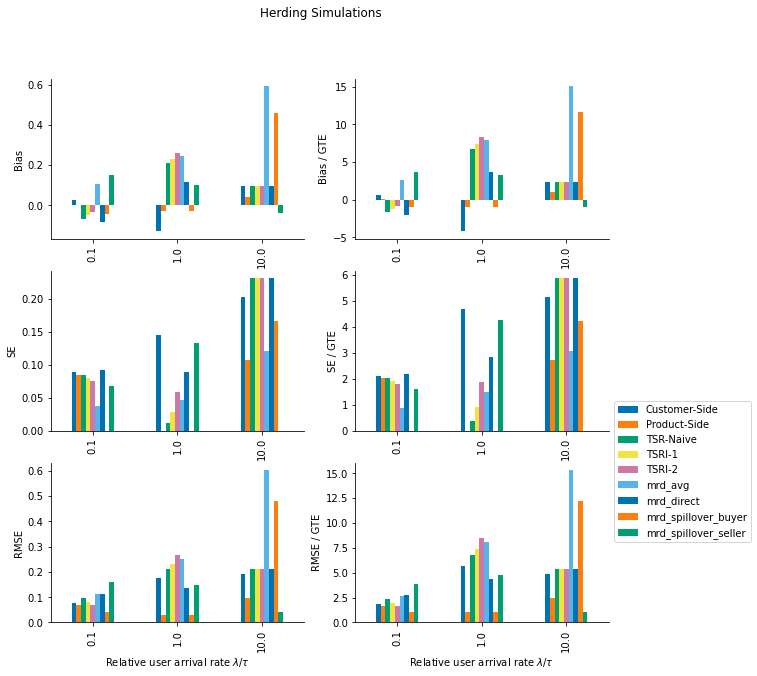

In [14]:
sim_wrapper.plot_all_stats(est_stats_herding, "Herding Simulations")

## Visualizations: competition

In [8]:
est_stats_competition = pd.read_csv("sample_total_stats_competition.csv", index_col=["estimator_type", "lambda"])

est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

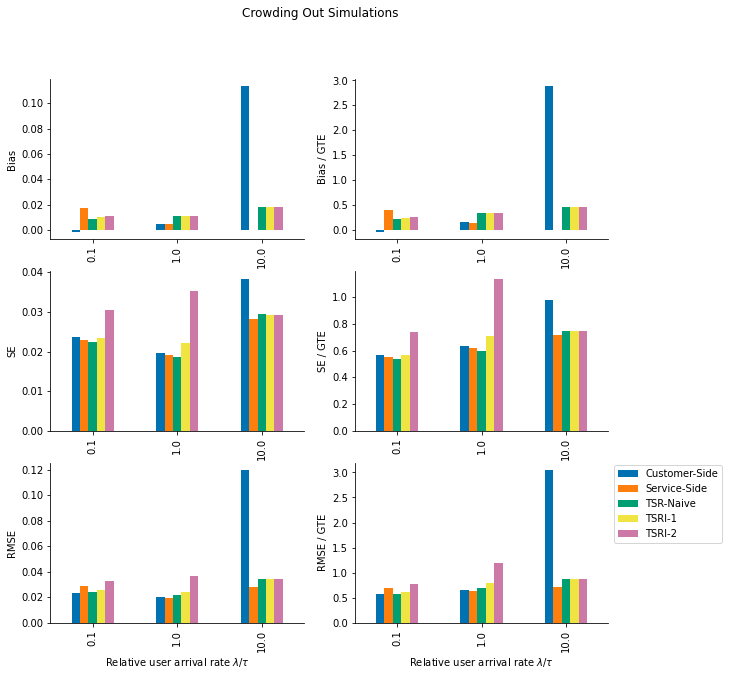

In [10]:
sim_wrapper.plot_all_stats(est_stats_competition, "Crowding Out Simulations")

## Visualizations: Herding, no recency

In [11]:
est_stats_herding_no_recency = pd.read_csv("sample_total_stats_herding_no_recency.csv", index_col=["estimator_type", "lambda"])

est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

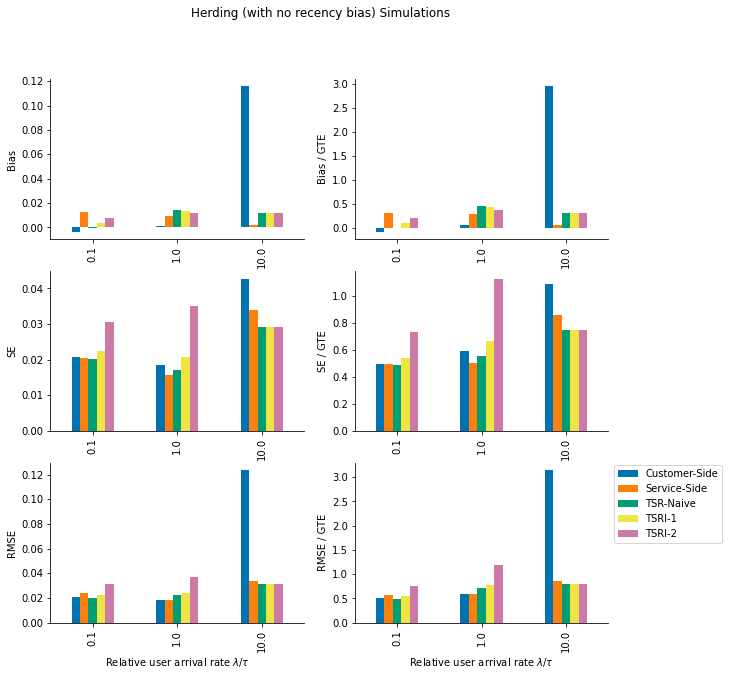

In [13]:
sim_wrapper.plot_all_stats(est_stats_herding_no_recency, "Herding (with no recency bias) Simulations")